<a href="https://colab.research.google.com/github/mohameddhameem/LearnPyTorch/blob/master/GRU_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GRU Language Model

In [1]:
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

#Other essential libraries
from collections import namedtuple

import numpy as np
from tqdm import tqdm

import pandas as pd

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
!pip install -U gensim==3.7.1

     |████████████████████████████████| 24.2MB 126kB/s 
  Found existing installation: gensim 3.8.1
    Uninstalling gensim-3.8.1:
      Successfully uninstalled gensim-3.8.1


In [2]:
import gensim
print(gensim.__version__)
# gensim version has to be 
from gensim.corpora import Dictionary

3.7.1


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})
#Set the random seed
torch.manual_seed(42)

In [0]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [0]:
import os
import requests
import io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    #Lets try to download the file if its not available in the system
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

In [0]:
# Tokenize the text.
tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(text)]

In [0]:
class KilgariffDataset(nn.Module):
    def __init__(self, texts):
        self.texts = texts
        
        # Initialize the vocab 
        special_tokens = {'<pad>': 0, '<unk>':1, '<s>':2, '</s>':3}
        self.vocab = Dictionary(texts)
        self.vocab.patch_with_special_tokens(special_tokens)
        
        # Keep track of the vocab size.
        self.vocab_size = len(self.vocab)
        
        # Keep track of how many data points.
        self._len = len(texts)
        
        # Find the longest text in the data.
        self.max_len = max(len(txt) for txt in texts) 
        
    def __getitem__(self, index):
        vectorized_sent = self.vectorize(self.texts[index])
        x_len = len(vectorized_sent)
        # To pad the sentence:
        # Pad left = 0; Pad right = max_len - len of sent.
        pad_dim = (0, self.max_len - len(vectorized_sent))
        vectorized_sent = F.pad(vectorized_sent, pad_dim, 'constant')
        return {'x':vectorized_sent[:-1], 
                'y':vectorized_sent[1:], 
                'x_len':x_len}
    
    def __len__(self):
        return self._len
    
    def vectorize(self, tokens, start_idx=2, end_idx=3):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        # Lets just cast list of indices into torch tensors directly =)
        
        vectorized_sent = [start_idx] + self.vocab.doc2idx(tokens) + [end_idx]
        return torch.tensor(vectorized_sent)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [9]:
kilgariff_data = KilgariffDataset(tokenized_text)
len(kilgariff_data.vocab)

1430

In [10]:
batch_size = 10
dataloader = DataLoader(dataset=kilgariff_data, batch_size=batch_size, shuffle=True)

for data_dict in dataloader:
    # Sort indices of data in batch by lengths.
    sorted_indices = np.array(data_dict['x_len']).argsort()[::-1].tolist()
    data_batch = {name:_tensor[sorted_indices]
                  for name, _tensor in data_dict.items()}
    print(data_batch)
    break

{'x': tensor([[   2,  125,  738,  ...,    0,    0,    0],
        [   2,  644,   48,  ...,    0,    0,    0],
        [   2,   30,   58,  ...,    0,    0,    0],
        ...,
        [   2, 1010,    4,  ...,    0,    0,    0],
        [   2,   35, 1112,  ...,    0,    0,    0],
        [   2,   45,    8,  ...,    0,    0,    0]]), 'y': tensor([[ 125,  738,   83,  ...,    0,    0,    0],
        [ 644,   48,  104,  ...,    0,    0,    0],
        [  30,   58,   69,  ...,    0,    0,    0],
        ...,
        [1010,    4, 1011,  ...,    0,    0,    0],
        [  35, 1112, 1257,  ...,    0,    0,    0],
        [  45,    8, 1130,  ...,    0,    0,    0]]), 'x_len': tensor([98, 60, 48, 45, 24, 22, 18, 14, 13,  6])}


In [0]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super(Generator, self).__init__()

        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # Initialize the GRU with the 
        # - size of the input (i.e. embedding layer)
        # - size of the hidden layer 
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize the "classifier" layer to map the RNN outputs
        # to the vocabulary. Remember we need to -1 because the 
        # vectorized sentence we left out one token for both x and y:
        # - size of hidden_size of the GRU output.
        # - size of vocabulary
        self.classifier = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs, use_softmax=False, hidden=None):
        # Look up for the embeddings for the input word indices.
        embedded = self.embedding(inputs)
        # Put the embedded inputs into the GRU.
        output, hidden = self.gru(embedded, hidden)
        
        # Matrix manipulation magic.
        batch_size, sequence_len, hidden_size = output.shape
        # Technically, linear layer takes a 2-D matrix as input, so more manipulation...
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)
        # Apply dropout.
        output = F.dropout(output, 0.5)
        # Put it through the classifier
        # And reshape it to [batch_size x sequence_len x vocab_size]
        output = self.classifier(output).view(batch_size, sequence_len, -1)
        
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)       


In [0]:
# Set the hidden_size of the GRU 
embed_size = 12
hidden_size = 10
num_layers = 1

_encoder = Generator(len(kilgariff_data.vocab), embed_size, hidden_size, num_layers)

In [0]:
# Take a batch.
batch_size = 15
dataloader = DataLoader(dataset=kilgariff_data, batch_size=batch_size, shuffle=True)

_batch = next(iter(dataloader))
_inputs, _lengths = _batch['x'], _batch['x_len']
_targets = _batch['y']

In [14]:
_output, _hidden = _encoder(_inputs)
print('Output sizes:\t', _output.shape)
print('Input sizes:\t', batch_size, kilgariff_data.max_len -1, len(kilgariff_data.vocab))
print('Target sizes:\t', _targets.shape)

Output sizes:	 torch.Size([15, 184, 1430])
Input sizes:	 15 184 1430
Target sizes:	 torch.Size([15, 184])


In [15]:
_output.shape

torch.Size([15, 184, 1430])

In [16]:
_output[-1].shape

torch.Size([184, 1430])

In [17]:
_, predicted_indices = torch.max(_output, dim=1)
print(predicted_indices.shape)

torch.Size([15, 1430])


In [18]:
_hyper = ['embed_size', 'hidden_size', 'num_layers',
          'loss_func', 'learning_rate', 'optimizer', 'batch_size']
Hyperparams = namedtuple('Hyperparams', _hyper)


hyperparams = Hyperparams(embed_size=250, hidden_size=250, num_layers=1,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=245)

hyperparams

Hyperparams(embed_size=250, hidden_size=250, num_layers=1, loss_func=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, learning_rate=0.03, optimizer=<class 'torch.optim.adam.Adam'>, batch_size=245)

In [0]:
# Training routine.
def train(num_epochs, dataloader, model, criterion, optimizer):
    losses = []
    plt.ion()
    for _e in range(num_epochs):
        for batch in tqdm(dataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            loss = criterion(output.permute(0, 2, 1), y)
            loss.backward()
            optimizer.step()
            losses.append(loss.float().data)

        clear_output(wait=True)
        plt.plot(losses)
        plt.pause(0.05)


def initialize_data_model_optim_loss(hyperparams):
    # Initialize the dataset and dataloader.
    kilgariff_data = KilgariffDataset(tokenized_text)
    dataloader = DataLoader(dataset=kilgariff_data, 
                            batch_size=hyperparams.batch_size, 
                            shuffle=True)

    # Loss function.
    criterion = hyperparams.loss_func(ignore_index=kilgariff_data.vocab.token2id['<pad>'], 
                                      reduction='mean')

    # Model.
    model = Generator(len(kilgariff_data.vocab), hyperparams.embed_size, 
                      hyperparams.hidden_size, hyperparams.num_layers).to(device)

    # Optimizer.
    optimizer = hyperparams.optimizer(model.parameters(), lr=hyperparams.learning_rate)
    
    return dataloader, model, optimizer, criterion

In [0]:
def generate_example(model, temperature=1.0, max_len=100, hidden_state=None):
    start_token, start_idx = '<s>', 2
    # Start state.
    inputs = torch.tensor(kilgariff_data.vocab.token2id[start_token]).unsqueeze(0).unsqueeze(0).to(device)

    sentence = [start_token]
    i = 0
    while i < max_len and sentence[-1] not in ['</s>', '<pad>']:
        i += 1
        
        embedded = model.embedding(inputs)
        output, hidden_state = model.gru(embedded, hidden_state)

        batch_size, sequence_len, hidden_size = output.shape
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)    
        output = model.classifier(output).view(batch_size, sequence_len, -1).squeeze(0)
        #_, prediction = torch.max(F.softmax(output, dim=2), dim=2)
        
        word_weights = output.div(temperature).exp().cpu()
        if len(word_weights.shape) > 1:
            word_weights = word_weights[-1] # Pick the last word.    
        word_idx = torch.multinomial(word_weights, 1).view(-1)
        
        sentence.append(kilgariff_data.vocab[int(word_idx)])
        
        inputs = tensor([kilgariff_data.vocab.token2id[word] for word in sentence]).unsqueeze(0).to(device)
    print(' '.join(sentence))

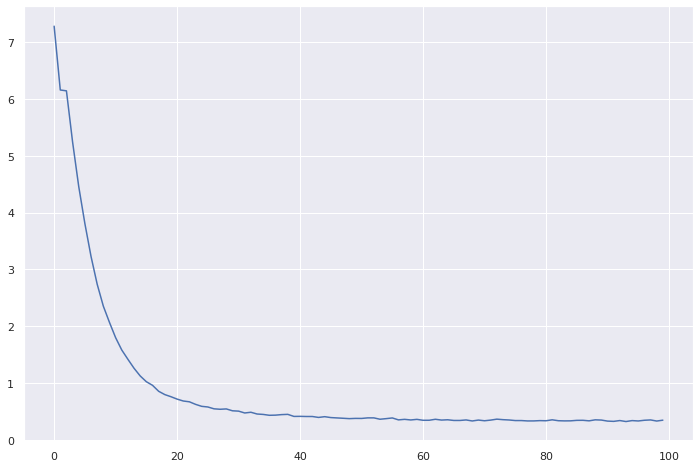

In [21]:
hyperparams = Hyperparams(embed_size=250, hidden_size=250, num_layers=1,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=250)

dataloader, model, optimizer, criterion = initialize_data_model_optim_loss(hyperparams)

train(100, dataloader, model, criterion, optimizer)

In [22]:
for _ in range(10):
    generate_example(model)

<s> however this does not factor in the arbitrariness of the word occurring at all in the corpus : in a corpus ten times the size , there would be roughly ten times the number of singletons and doubletons in the corpus , most of which would not have occurred at all in the original corpus . </s>
<s> language is never , ever , ever , random adam kilgarriff abstract language users never choose words randomly , and language is essentially non-random . </s>
<s> if the likelihood is low , we reject h0. the problem for empirical linguistics is that language is not random , so the null hypothesis is never true . </s>
<s> polytech publishers. pedersen , ted 1996 fishing for exactness . </s>
<s> harlow : longman. leech , geoffrey and roger fallon 1992 computer corpora — what do they tell us about culture ? </s>
<s> we do not always have enough data to reject the null hypothesis , but that is a distinct issue : wherever there is enough data , it is rejected . </s>
<s> biometrika 40 , 237⫺264. gre

In [0]:
import json
torch.save(model.state_dict(), 'gru-model.pth')

hyperparams_str = Hyperparams(embed_size=250, hidden_size=250, num_layers=1,
                          loss_func='nn.CrossEntropyLoss',
                          learning_rate=0.03, optimizer='optim.Adam', batch_size=250)

with open('gru-model.json', 'w') as fout:
    json.dump(dict(hyperparams_str._asdict()), fout)